# Training a Denoising Diffusion Probabilistic Model from Scratch

In [26]:
import os
import random
import pathlib
from typing import Optional
from dataclasses import dataclass

import glob
from PIL import Image
import numpy as np

import torch
import torch.nn.functional as F
import torch
from torch.optim import Adam, RAdam
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
import multiprocessing

from torchvision import transforms 
import torchvision
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [2]:
# Make results fully reproducible
seed = 42
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

In [3]:
# Name of each GPU
for i in range(torch.cuda.device_count()):
    print(i, torch.cuda.get_device_name(i))

0 NVIDIA GeForce RTX 3060
1 NVIDIA T500


In [5]:
!nvidia-smi

Wed Nov 12 08:23:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.105.08             Driver Version: 580.105.08     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA T500                    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   52C    P8            N/A  / 5001W |       5MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Dataset

We are going to use the Stanford Cars dataset. It consists of 196 classes of cars with a total of 16185 images. However, we do not need any label, nor a test dataset. Additionally, we are going to resize the images to `64x64` for easier processing.

Note that the original dataset [https://ai.stanford.edu/~jkrause/cars/car_dataset.html](https://ai.stanford.edu/~jkrause/cars/car_dataset.html) is not available anymore.
Instead, we can download it from Kaggle or HuggingFace.

- I downloaded it from [https://www.kaggle.com/datasets/eduardo4jesus/stanford-cars-dataset](https://www.kaggle.com/datasets/eduardo4jesus/stanford-cars-dataset) manually and unzipped it to `./data`. Unfortunately, the programmagtic `kagglehub` option didn't work for me.
- The alternative would be to download it from HuggingFace: [https://huggingface.co/datasets/tanganke/stanford_cars](https://huggingface.co/datasets/tanganke/stanford_cars); in that case, either the structure of the dataset or the code which instantiates the dataloaders need to be modified.

I have manually arranged this structure in `./data`:

```
data/
    stanford_cars/
        train/
            00001.jpg
            ...
        test/
            00001.jpg
            ...
        devkit/ (unused, since we don't need annotations)
            car_test_annos.mat
            car_train_annos.mat
            ...
```

This section builds a Pytorch Dataset & Dataloader based on the images.

In [71]:
IMG_SIZE = 64
BATCH_SIZE = 100
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class CarImagesDataset(Dataset):
    def __init__(
            self,
            root_dir: str | pathlib.Path,
            transform: Optional[transforms.Compose] = None
        ):
        self.transform = transform
        # Find all jpg files in the directory
        self.image_paths = list(pathlib.Path(root_dir).glob("*.jpg"))
        
    def __len__(self) -> int:
        return len(self.image_paths)
    
    def __getitem__(self, idx: int) -> tuple[torch.Tensor, int]:
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)
            
        return image, 0  # Return dummy label since we don't need it

In [8]:
def get_dataset(path: str | pathlib.Path) -> Dataset:
    data_transform = transforms.Compose(
        [
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            # Flip horizontally with probability 50%
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            # Scale data to [-1,1] 
            transforms.Normalize(0.5, 0.5)
        ]
    )
    
    # Use custom dataset for your flat folder structure
    train = CarImagesDataset(
        root_dir=pathlib.Path(path) / "train", 
        transform=data_transform
    )

    test = CarImagesDataset(
        root_dir=pathlib.Path(path) / "test", 
        transform=data_transform
    )
    
    return torch.utils.data.ConcatDataset([train, test])

In [9]:
data = get_dataset("./data/stanford_cars")
dataloader = DataLoader(
    data, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    drop_last=False, 
    pin_memory=True, 
    num_workers=multiprocessing.cpu_count(),
    persistent_workers=True
)

In [18]:
def display_sequence(imgs: torch.Tensor, dpi: int = 75, nrow: int = 8):    
    fig, sub = plt.subplots(dpi=dpi)
    sub.imshow(
        np.transpose(
            make_grid(
                imgs, 
                padding=0,
                normalize=True,
                nrow=nrow,
            ).cpu(),
            (1,2,0)
        )
    )
    _ = sub.axis("off")
    
    return fig

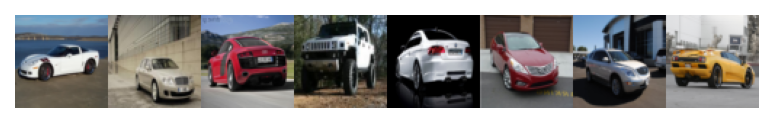

In [19]:
# Get a batch
batch, _ = next(iter(dataloader))
# Display it
_ = display_sequence(batch[:8], dpi=150)

## Forward Diffusion

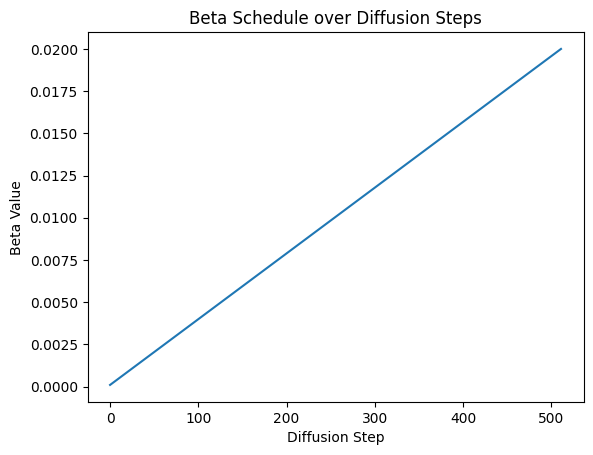

In [13]:
# Beta schedule
# Number of diffusion steps
T = 512
betas = torch.linspace(start=0.0001, end=0.02, steps=T)  # linear schedule

plt.plot(range(T), betas.numpy(), label='Beta Values')
plt.xlabel('Diffusion Step')
plt.ylabel('Beta Value')
_ = plt.title('Beta Schedule over Diffusion Steps')

**Formulae**:

Forward diffusion:

$x_t = q(x_t | x_{t-1}) = x_{t-1}\sqrt{1-\beta_t} + \epsilon_{t-1}\sqrt{\beta_t} = N(x_{t-1}\sqrt{1-\beta_t}, \beta_t I)$

$\epsilon_{t-1}\sqrt{\beta_t}$: noise map added during the forward/training phase

Reparametrization of the noise:

$\bar{\alpha_t} = \prod_{i=0}^{t}{\alpha_i} \prod_{i=0}^{t}{1 - \beta_i}$,

$x_t = q(x_t | x_0) = x_0\sqrt{\bar{\alpha_t}} + \epsilon\sqrt{1 - \bar{\alpha_t}} = N(x_0\sqrt{\bar{\alpha}_t}, (1-\bar{\alpha}_t) I)$

Reverse diffusion:

$x_{t-1} = p(x_{t-1} | x_t) = \frac{1}{\sqrt{\alpha_t}} (x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha_t}}}\epsilon_{\theta}) + \sigma_t z$

$z \sim N(0,I)$

$\sigma_t^2 = \frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_t} \beta_t$

$\epsilon_{\theta}$: noise map predicted by the *UNet*


In [52]:
@dataclass
class Config:
    img_size: int = 64
    batch_size: int = 100
    T: int = 512
    beta_start: float = 0.0001
    beta_end: float = 0.02

    def __post_init__(self):
        # betas: linear schedule
        self.betas = torch.linspace(self.beta_start, self.beta_end, self.T)
        # alphas
        self.alphas = 1.0 - self.betas
        # alpha bar
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        # alpha bar at t-1
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.)
        # sqrt of alpha bar
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        # 1 / sqrt(alpha bar)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
        # sqrt of one minus alpha bar
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)
        # sigma_t
        self.posterior_variance = (
            self.betas * (1 - self.alphas_cumprod_prev) / (1 - self.alphas_cumprod)
        )

    def to(self, device):
        for k, v in self.__dict__.items():
            if isinstance(v, torch.Tensor):
                setattr(self, k, v.to(device))
        return self

In [53]:
cfg = Config()

In [73]:
@torch.no_grad()
def visualize_forward_diffusion(
    image: torch.Tensor,
    config: Config,
    device: str | torch.device = "cpu",
    num_images: int = 16,
    dpi: int = 75,
    interleave: bool = False
) -> tuple:
    """
    Generate the forward sequence of noisy images taking the input image to pure noise.
    """
    imgs = []
    noises = []

    # Move to device
    config = config.to(device)
    image = image.to(device)

    # Visualize only num_images diffusion steps, instead of all of them
    stepsize = config.T // num_images
    for i in range(0, config.T, stepsize):
        t = torch.full((1,), i, device=device, dtype=torch.long)

        # Forward diffusion process
        bs = image.shape[0]
        noise = torch.randn_like(image, device=device)
        img = (
            config.sqrt_alphas_cumprod[t].view(bs, 1, 1, 1) * image + 
            config.sqrt_one_minus_alphas_cumprod[t].view(bs, 1, 1, 1) * noise
        )

        imgs.append(torch.clamp(img, -1, 1).squeeze(dim=0))
        noises.append(torch.clamp(noise, -1, 1).squeeze(dim=0))
    
    if interleave:
        imgs = [item for pair in zip(imgs, noises) for item in pair]
        
    fig = display_sequence(imgs, dpi=dpi)
    
    return fig, imgs[-1]

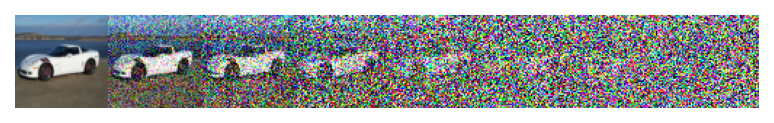

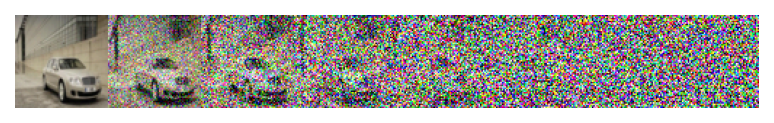

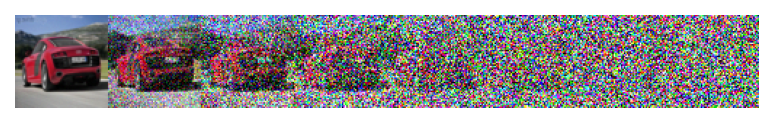

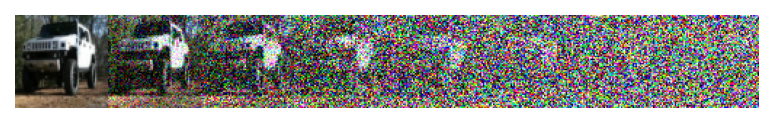

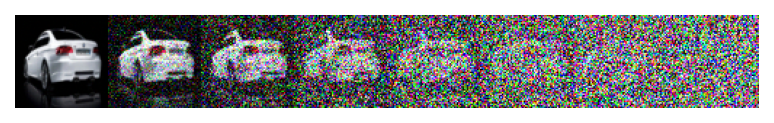

In [74]:
for image in batch[:5]:
    _ = visualize_forward_diffusion(
        image.unsqueeze(dim=0),
        cfg,
        num_images=7,
        dpi=150,
        interleave=False,
        device=DEVICE
    )

## *U-Net* Model

In [75]:
from unet import UNet

# model = UNet(ch_mults = (1, 2, 2, 2))  # Complex model for longer training
model = UNet(ch_mults = (1, 2, 1, 1))  # Simpler model for quicker testing

n_params = sum(p.numel() for p in model.parameters())
print(
    f"Number of parameters: {n_params:,}"
)
model = model.to(DEVICE)
cfg = cfg.to(DEVICE)


Number of parameters: 9,139,651


In [76]:
@torch.no_grad()
def run_inference(
    input_noise: torch.Tensor,
    model: torch.nn.Module,
    config: Config,
    return_all: bool = False,
    device: str | torch.device = "cpu",
) -> torch.Tensor:
    """
    Implements the sampling algorithm from the DDPM paper
    """
    config = config.to(device)
    input_noise = input_noise.to(device)
    model = model.to(device)

    x = input_noise
    bs = x.shape[0]
    
    imgs = []
    
    for time_step in range(0, config.T)[::-1]:
        
        noise = torch.randn_like(x) if time_step > 0 else 0
        
        t = torch.full((bs,), time_step, device=device, dtype=torch.long)
        
        x = config.sqrt_recip_alphas[t].view(bs, 1, 1, 1) * (
            x - config.betas[t].view(bs, 1, 1, 1) * model(x, t) / 
            config.sqrt_one_minus_alphas_cumprod[t].view(bs, 1, 1, 1)
        ) + torch.sqrt(config.posterior_variance[t].view(bs, 1, 1, 1)) * noise
        
        imgs.append(torch.clamp(x, -1, 1))
    
    if return_all:
        return imgs
    else:
        return imgs[-1] 

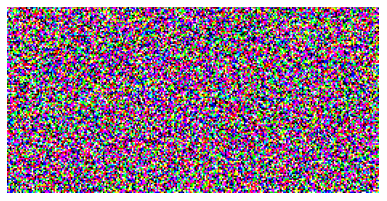

In [77]:
input_noise = torch.randn((8, 3, IMG_SIZE, IMG_SIZE), device=DEVICE)
imgs = run_inference(input_noise, model, cfg, device=DEVICE)
_ = display_sequence(imgs, dpi=75, nrow=4)

## Training